Going to attempt to build some keras layers for text and benchmark that against datarobot text-only models on the leaderboard.   Going to use the file DR_zid_sw_2016-06-30.gz  which corresponds to https://app.datarobot.com/projects/586de94dc8089157b1c70876/models

These are the text models below

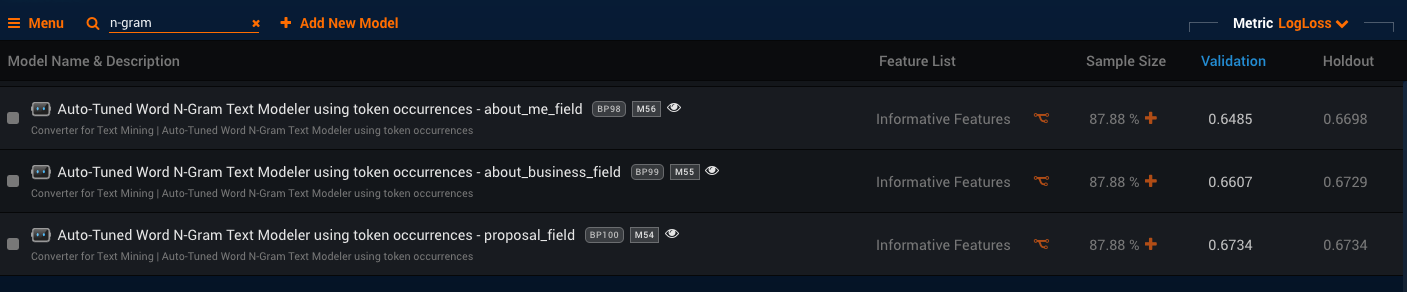

In [1]:
from IPython.display import Image
Image("text_models.png")

### Import Data

In [2]:
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.layers.core import Dense, Dropout, Flatten
from keras.models import Sequential
from keras.layers.convolutional import Convolution1D
from keras.layers.embeddings import Embedding
from keras.layers.pooling import MaxPooling1D
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam #https://keras.io/optimizers/
from keras.layers.normalization import BatchNormalization #https://keras.io/layers/normalization/
from keras.regularizers import WeightRegularizer #https://keras.io/regularizers/
pd.options.display.max_columns = 100

Using Theano backend.
Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)


In [3]:
df = pd.read_csv('DR_zid_sw_2016-06-30.gz')

Lets tackle the text feature proposal_field first

In [4]:
df_text = df[['proposal_field', 'default_flag','part']]
#Fill null values with empty string
df.proposal_field[df.proposal_field.isnull()] = ''
df_text.head()

/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,proposal_field,default_flag,part
0,Thank you for giving me this opportunity to ap...,0,t
1,The first loan given will be used to aid in re...,1,t
2,The first loan given will be used to purchase ...,0,t
3,Thank you all the zidisha Microfinance for the...,1,t
4,"I will use KES 15,000 to add up to my savings ...",0,t


In [4]:
#set max vocabulary
max_words = 3000
text_tokenizer = Tokenizer(nb_words=max_words)

In [5]:
#train validation holdout split
train = df[df.part == 't'].proposal_field.values.tolist()
train_labels = df[df.part == 't'].default_flag.values.tolist()

validation = df[df.part == 'v'].proposal_field.values.tolist()
validation_labels =  df[df.part == 'v'].default_flag.values.tolist()

holdout = df[df.part == 'h'].proposal_field.values.tolist()
holdout_labels = df[df.part == 'h'].default_flag.values.tolist()

#Fit data on training set
text_tokenizer.fit_on_texts(train)

In [6]:
#Transform datasets
mode = 'binary'
train_transformed = text_tokenizer.texts_to_matrix(train, mode = mode)
validation_transformed = text_tokenizer.texts_to_matrix(validation, mode = mode)
holdout_transformed = text_tokenizer.texts_to_matrix(holdout, mode = mode)

In [7]:
model = Sequential([ 
    #Embedding(max_words, 32, input_length=seq_len, dropout=0.2),
    BatchNormalization(input_shape=(max_words,)), #Normalizes input
    #Convolution1D(2, 10, border_mode='same', activation='relu'),
    #Flatten(),    
    #Dense(2, activation='relu', W_regularizer=WeightRegularizer(l1=0.1, l2=0.1)),
    Dropout(.2),
    #Dense(100, activation='relu', W_regularizer=WeightRegularizer(l1=0.1, l2=0.1)),
    #BatchNormalization(),
    #Dropout(.1),
    Dense(1, activation='sigmoid',W_regularizer=WeightRegularizer(l1=.01, l2=0.2))])

model.compile(loss='binary_crossentropy', optimizer=Adam(lr = .0001), metrics=['accuracy'])

In [8]:
model.fit(train_transformed, train_labels, validation_data=(validation_transformed, validation_labels), 
          nb_epoch=6, batch_size=64)

Train on 20266 samples, validate on 2408 samples
Epoch 1/6
20266/20266 [==============================] - 2s - loss: 1.4296 - acc: 0.5236 - val_loss: 1.1402 - val_acc: 0.4336
Epoch 2/6
20266/20266 [==============================] - 2s - loss: 0.9318 - acc: 0.5671 - val_loss: 0.8281 - val_acc: 0.5336
Epoch 3/6
20266/20266 [==============================] - 2s - loss: 0.7462 - acc: 0.5925 - val_loss: 0.7271 - val_acc: 0.5544
Epoch 4/6
20266/20266 [==============================] - 2s - loss: 0.6997 - acc: 0.6023 - val_loss: 0.7065 - val_acc: 0.5440
Epoch 5/6
20266/20266 [==============================] - 2s - loss: 0.6893 - acc: 0.6057 - val_loss: 0.7052 - val_acc: 0.5216
Epoch 6/6
20266/20266 [==============================] - 2s - loss: 0.6861 - acc: 0.6034 - val_loss: 0.7075 - val_acc: 0.5012


In [9]:
model.evaluate(holdout_transformed, holdout_labels)

387/387 [==============================] - 0s     


[0.70825329569267059, 0.51421188645892668]

# Part 2: Try Convolutional Network

In [10]:
df.proposal_field.apply(lambda x: len(x)).describe()

count    23061.000000
mean       495.843198
std        365.120189
min          0.000000
25%        305.000000
50%        431.000000
75%        618.000000
max      13586.000000
Name: proposal_field, dtype: float64

### Pre-process Text

In [7]:
seq_len = 500

seq_train_transformed = text_tokenizer.texts_to_sequences(train)
trn = pad_sequences(seq_train_transformed, maxlen=seq_len, value=0)

seq_validation_transformed = text_tokenizer.texts_to_sequences(validation)
vld = pad_sequences(seq_validation_transformed, maxlen=seq_len, value=0)

### Define Network Topology

This took lots of trial and error.  Intuition behind network topology:

- I found from previous step that less dense layers performed better.  Infact, when only having 1 dense layer with just a single node did the best!  Therefore, I eliminated all Dense layers and focused on convolution to see if I could improve upon the last model.


- I wanted to emulate n-gram (bag of words, bi-grams, tri-grams, etc. but I wanted to instead try something conceptually similar (and more elegant), which is to use a 1-dimensional convolution that slides over the text.   A big window of about 15 words long seemd to work the best in this case.  


- I increased regularization to the point where it did not negatively impact model performance, with the idea that I want the most constrained model that is the most accurate.  I found that L1 regularization was not effective in the last layer and stuck with tuning L2

### TODO:  

- Checkpoint best model during training, instead of just getting the model at the end of predefined epoch runs

In [12]:
model_conv = Sequential([ 
    Embedding(max_words, 3, input_length=seq_len, dropout=0.2),
    Dropout(.5),
    Convolution1D(2, 15, border_mode='same', activation='tanh'),
    BatchNormalization(), #Normalizes input
    MaxPooling1D(10),
    Flatten(),
    Dropout(.7),
    Dense(1, activation='sigmoid', W_regularizer=WeightRegularizer(l2=.95))])

model_conv.compile(loss='binary_crossentropy', optimizer=Adam(lr=1e-3), metrics=['accuracy'])

### Fit Model And Evaluate
Now we will train model and see score on validation set, and compare with DataRobot

In [13]:
model_conv.fit(trn, train_labels, validation_data=(vld, validation_labels),
              nb_epoch=4, batch_size=64)

Train on 20266 samples, validate on 2408 samples
Epoch 1/4
20266/20266 [==============================] - 2s - loss: 1.3136 - acc: 0.5471 - val_loss: 0.7316 - val_acc: 0.4020
Epoch 2/4
20266/20266 [==============================] - 2s - loss: 0.6813 - acc: 0.5898 - val_loss: 0.7176 - val_acc: 0.4020
Epoch 3/4
20266/20266 [==============================] - 2s - loss: 0.6762 - acc: 0.5900 - val_loss: 0.7223 - val_acc: 0.4020
Epoch 4/4
20266/20266 [==============================] - 2s - loss: 0.6754 - acc: 0.5900 - val_loss: 0.7273 - val_acc: 0.4020


** I noticed model start to diverge after a while, so I slowed down learning rate and kept going **

In [14]:
model_conv.optimizer.lr = 1e-4

In [15]:
model_conv.fit(trn, train_labels, validation_data=(vld, validation_labels),
              nb_epoch=12, batch_size=64)

Train on 20266 samples, validate on 2408 samples
Epoch 1/12
20266/20266 [==============================] - 2s - loss: 0.6748 - acc: 0.5900 - val_loss: 0.7250 - val_acc: 0.4020
Epoch 2/12
20266/20266 [==============================] - 2s - loss: 0.6744 - acc: 0.5900 - val_loss: 0.7184 - val_acc: 0.4020
Epoch 3/12
20266/20266 [==============================] - 2s - loss: 0.6731 - acc: 0.5900 - val_loss: 0.7132 - val_acc: 0.4020
Epoch 4/12
20266/20266 [==============================] - 2s - loss: 0.6730 - acc: 0.5900 - val_loss: 0.7115 - val_acc: 0.4020
Epoch 5/12
20266/20266 [==============================] - 2s - loss: 0.6714 - acc: 0.5900 - val_loss: 0.7085 - val_acc: 0.4020
Epoch 6/12
20266/20266 [==============================] - 2s - loss: 0.6706 - acc: 0.5900 - val_loss: 0.7054 - val_acc: 0.4053
Epoch 7/12
20266/20266 [==============================] - 2s - loss: 0.6684 - acc: 0.5903 - val_loss: 0.7055 - val_acc: 0.4053
Epoch 8/12
20266/20266 [==============================] - 2s -

**Evaluate on holdout set**

In [28]:
seq_holdout_transformed = text_tokenizer.texts_to_sequences(holdout)
hld = pad_sequences(seq_holdout_transformed, maxlen=seq_len, value=0)

In [17]:
model_conv.evaluate(hld, holdout_labels)

387/387 [==============================] - 0s     


[0.69409507374430812, 0.5038759691462652]

### Visualize Model Architecture

lets see holdout score

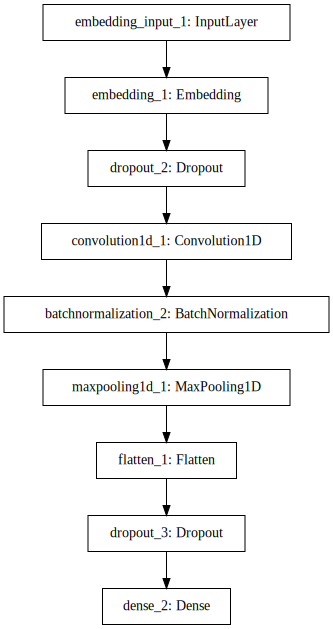

In [18]:
from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot

SVG(model_to_dot(model_conv).create(prog='dot', format='svg'))

In [19]:
model_conv.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_1 (Embedding)          (None, 500, 3)        9000        embedding_input_1[0][0]          
____________________________________________________________________________________________________
dropout_2 (Dropout)              (None, 500, 3)        0           embedding_1[0][0]                
____________________________________________________________________________________________________
convolution1d_1 (Convolution1D)  (None, 500, 2)        92          dropout_2[0][0]                  
____________________________________________________________________________________________________
batchnormalization_2 (BatchNorma (None, 500, 2)        8           convolution1d_1[0][0]            
___________________________________________________________________________________________

In [20]:
model_conv.compile(loss='binary_crossentropy', optimizer=Adam(lr=1e-3), metrics=['accuracy'])
model_conv.save('proposal_model_conv.h5')

## Visualize Semantics Relationship to Default

In [1]:
from keras.models import load_model
model_conv_final = load_model('proposal_model_conv.h5')

Using Theano backend.
Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)


In [2]:
vecs = model_conv_final.get_layer('embedding_1').get_weights()[0]

In [71]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=1019)
Y = tsne.fit_transform(vecs)
Y = Y[:600]

In [108]:
word_map = text_tokenizer.word_index
idx2word = [(v, k) for k, v in word_map.items()]
idx2word.sort()

In [109]:
words = [v for k, v in idx2word]
import sys
if sys.version[0] == '2':
    reload(sys)
    sys.setdefaultencoding("utf-8")

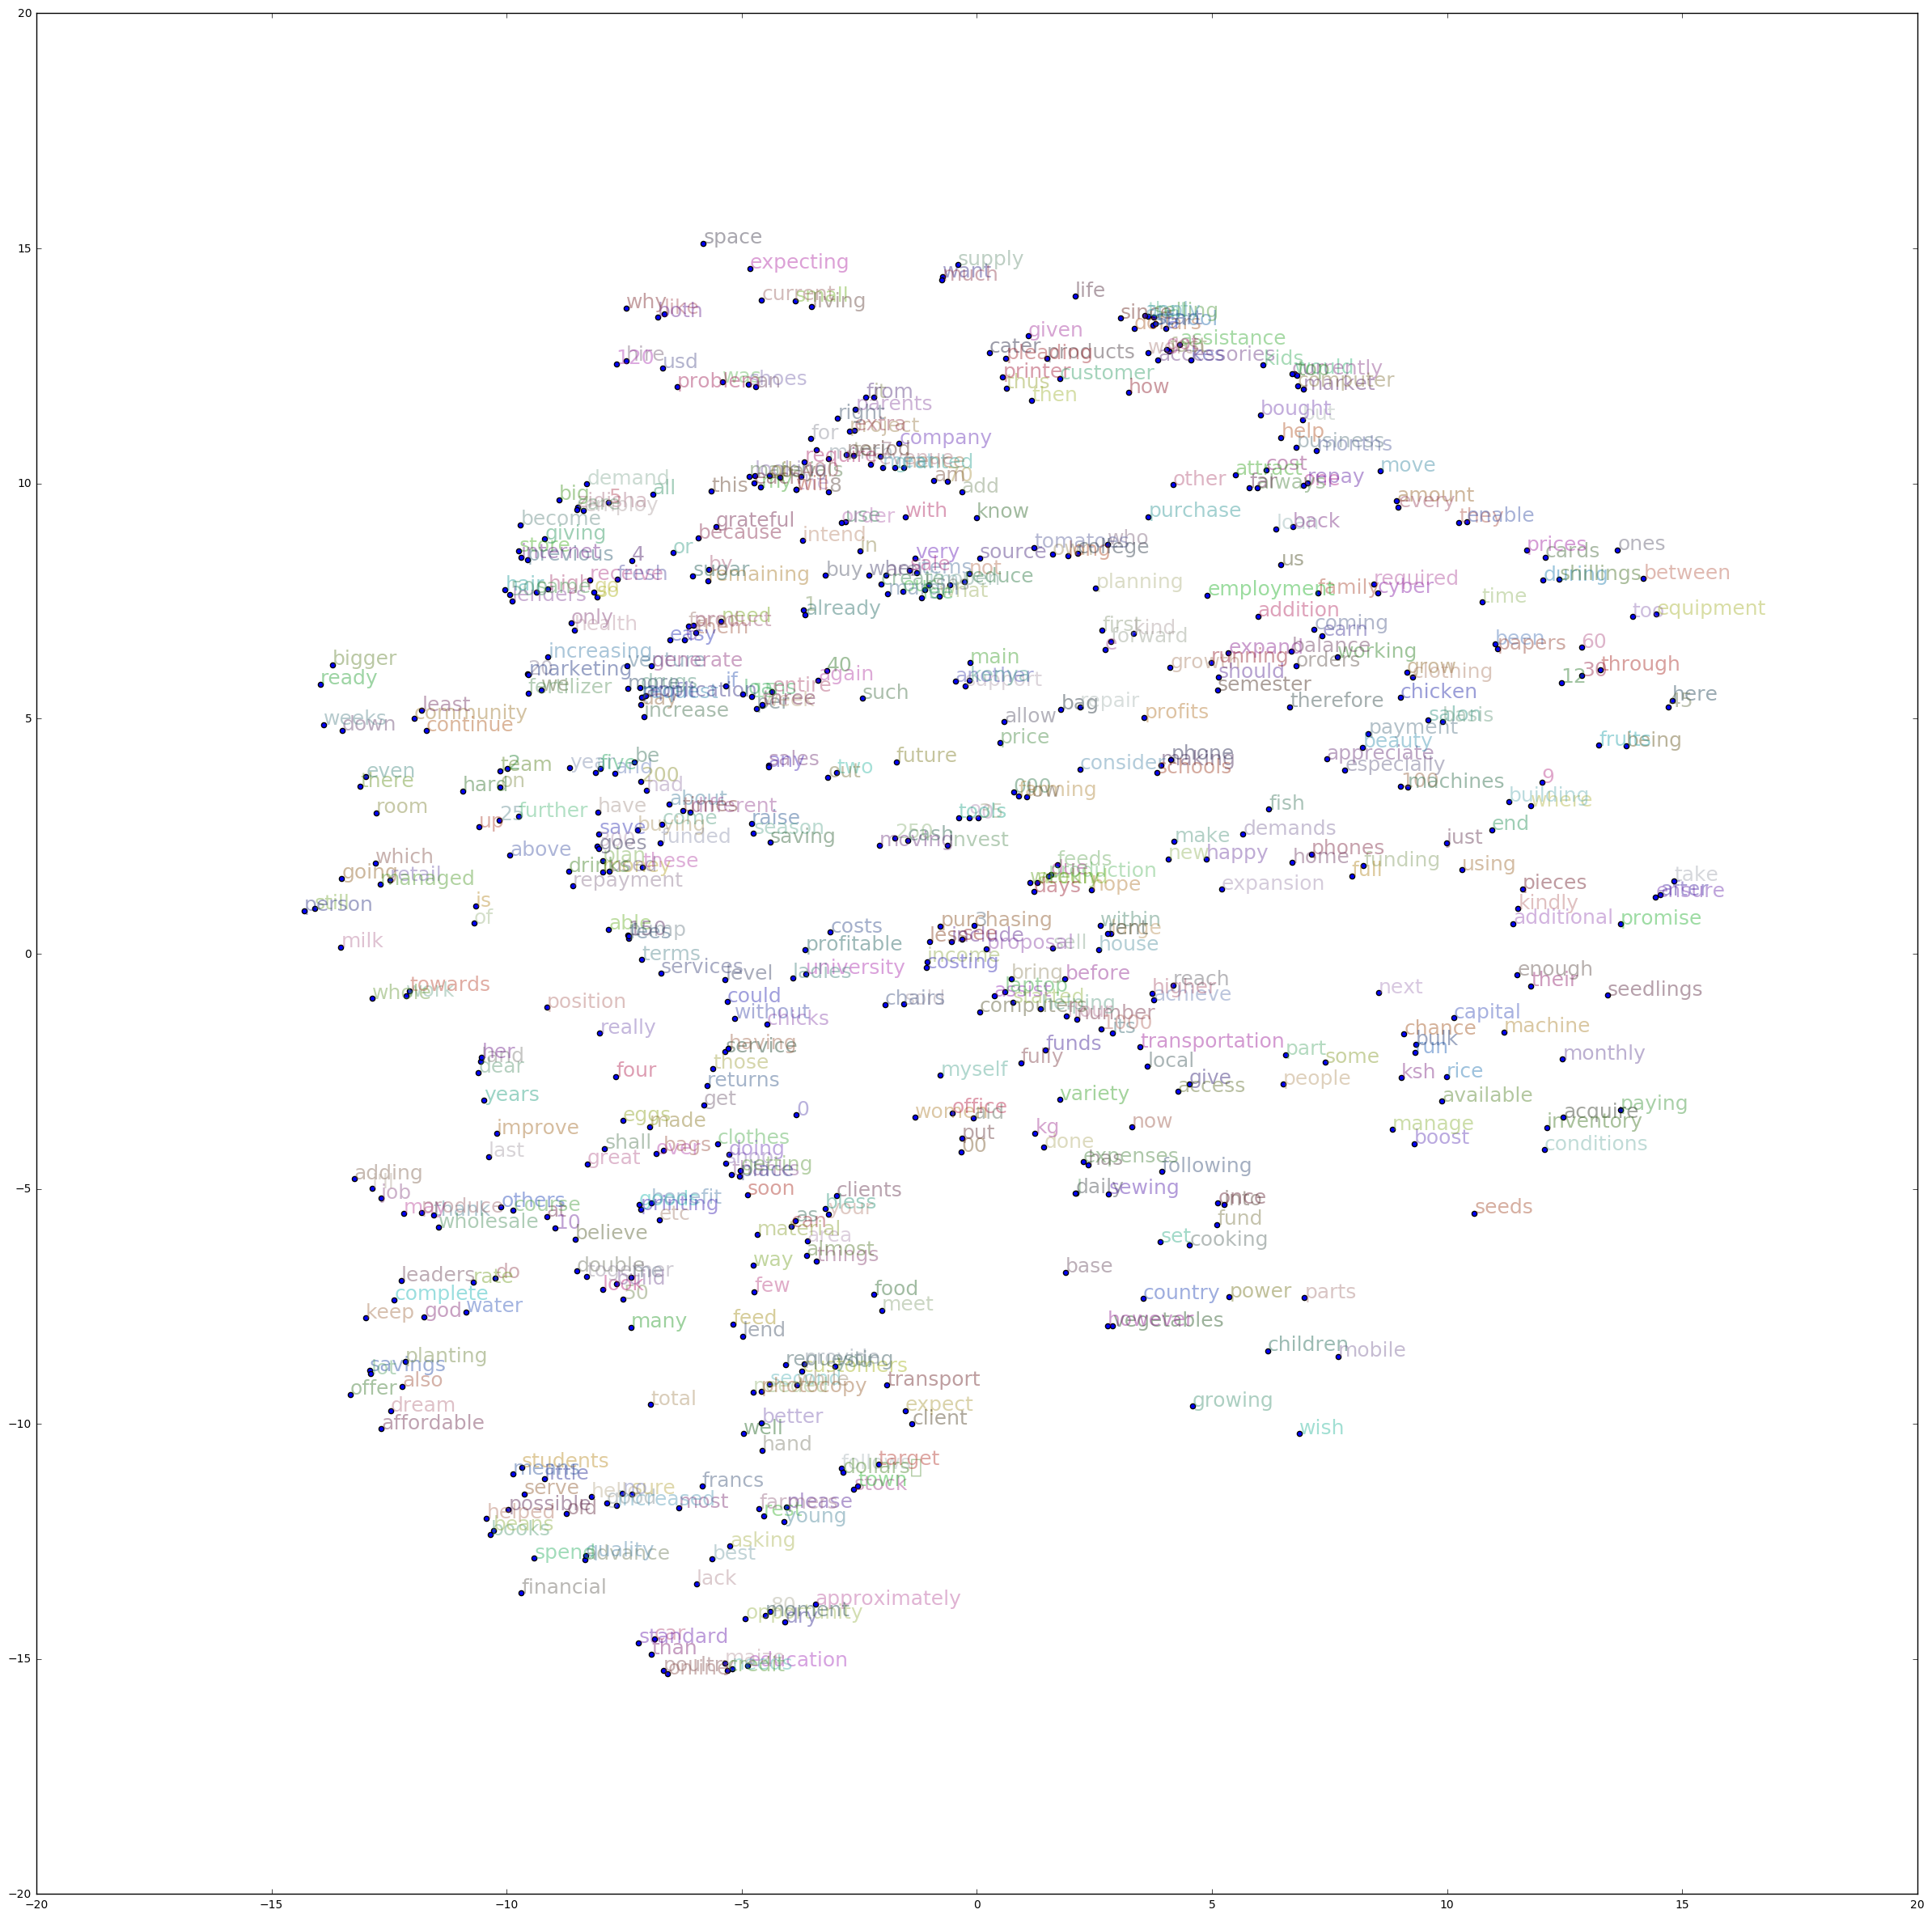

In [113]:
from matplotlib import pyplot as plt
import numpy as np

plt.figure(figsize=(30,30))
plt.scatter(Y[:, 0], Y[:, 1]);

for label, x, y in zip(words, Y[:, 0], Y[:, 1]):
    plt.text(x,y,label, color=np.random.rand(3)*0.7,
                 fontsize=18, alpha = .4)
plt.show()

## Try pre-trained embeddings

https://github.com/fastai/courses/blob/master/deeplearning1/nbs/lesson5.ipynb

In [8]:
import utils; reload(utils)
from utils import *
def load_vectors(loc):
    return (load_array(loc+'.dat'),
        pickle.load(open(loc+'_words.pkl','rb')),
        pickle.load(open(loc+'_idx.pkl','rb')))

vecs, words, wordidx = load_vectors('6B.50d')
def w2v(w): return vecs[wordidx[w]]

In [61]:
vecs.shape

(3000, 50)

In [10]:
vocab_size = max_words
word_map = text_tokenizer.word_index
idx2word = dict([(v, k) for k, v in word_map.items()])

def create_emb():
    n_fact = vecs.shape[1]
    emb = np.zeros((vocab_size, n_fact))

    for i in range(1,len(emb)):
        word = idx2word[i]
        if word and re.match(r"^[a-zA-Z0-9\-]*$", word) and (word in wordidx):
            src_idx = wordidx[word]
            emb[i] = vecs[src_idx]
        else:
            # If we can't find the word in glove, randomly initialize
            emb[i] = normal(scale=0.6, size=(n_fact,))

    # This is our "rare word" id - we want to randomly initialize
    emb[-1] = normal(scale=0.6, size=(n_fact,))
    emb/=3
    return emb

In [11]:
emb = create_emb()

In [12]:
len(emb)

3000

In [30]:
model = Sequential([
    Embedding(vocab_size, 50, input_length=seq_len, dropout=0.2, 
              weights=[emb], trainable=False),
    Dropout(0.25),
    Convolution1D(64, 5, border_mode='same', activation='relu'),
    Dropout(0.25),
    MaxPooling1D(),
    Flatten(),
    Dense(100, activation='relu'),
    Dropout(0.7),
    Dense(1, activation='sigmoid')])

model.compile(loss='binary_crossentropy', optimizer='rmsprop')

In [31]:
model.fit(trn, train_labels, validation_data=(vld, validation_labels),
              nb_epoch=12, batch_size=64)

Train on 20266 samples, validate on 2408 samples
Epoch 1/12
20266/20266 [==============================] - 6s - loss: 0.6756 - val_loss: 0.7078
Epoch 2/12
20266/20266 [==============================] - 6s - loss: 0.6725 - val_loss: 0.7087
Epoch 3/12
20266/20266 [==============================] - 6s - loss: 0.6705 - val_loss: 0.7010
Epoch 4/12
20266/20266 [==============================] - 6s - loss: 0.6686 - val_loss: 0.7012
Epoch 5/12
20266/20266 [==============================] - 6s - loss: 0.6684 - val_loss: 0.6973
Epoch 6/12
20266/20266 [==============================] - 6s - loss: 0.6672 - val_loss: 0.7004
Epoch 7/12
20266/20266 [==============================] - 6s - loss: 0.6660 - val_loss: 0.6976
Epoch 8/12
20266/20266 [==============================] - 6s - loss: 0.6641 - val_loss: 0.6958
Epoch 9/12
20266/20266 [==============================] - 6s - loss: 0.6632 - val_loss: 0.6900
Epoch 10/12
20266/20266 [==============================] - 6s - loss: 0.6635 - val_loss: 0.6908


In [32]:
model.evaluate(hld, holdout_labels)

387/387 [==============================] - 0s     


0.67955206654176536

In [37]:
model.summary()

INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.4--generic-x86_64-with-debian-stretch-sid-x86_64-2.7.12-64/lock_dir/lock


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_7 (Embedding)          (None, 500, 50)       150000      embedding_input_7[0][0]          
____________________________________________________________________________________________________
dropout_19 (Dropout)             (None, 500, 50)       0           embedding_7[0][0]                
____________________________________________________________________________________________________
convolution1d_7 (Convolution1D)  (None, 500, 64)       16064       dropout_19[0][0]                 
____________________________________________________________________________________________________
dropout_20 (Dropout)             (None, 500, 64)       0           convolution1d_7[0][0]            
___________________________________________________________________________________________

## Lets package up the text model

In [5]:
import bcolz
import pandas as pd
import sys
import re
import cPickle as pickle
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.layers.core import Dense, Dropout, Flatten
from keras.models import Sequential
from numpy.random import random, permutation, randn, normal, uniform, choice
from keras.layers.convolutional import Convolution1D
from keras.layers.embeddings import Embedding
from keras.layers.pooling import MaxPooling1D
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam #https://keras.io/optimizers/
from keras.layers.normalization import BatchNormalization #https://keras.io/layers/normalization/
from keras.regularizers import WeightRegularizer #https://keras.io/regularizers/
pd.options.display.max_columns = 100

In [30]:
class ZidishaTextModeling(object):

    def __init__(self, data_frame, text_field_name, label_name = 'default_flag', 
                 vocab_size = 3000, max_words_in_response = 700):
        
        #This is hard-coded embedding file available at http://www.platform.ai/models/glove/6B.50d.tgz
        self.embedding_loc='6B.50d'
        self.vecs, self.words, self.wordidx = self.load_vectors()
        self.vocab_size = vocab_size
        self.text_tokenizer = Tokenizer(nb_words=vocab_size)
        
        self.df = data_frame
        self.text_field_name = text_field_name
        self.label_name = label_name
        self.max_words_in_response = max_words_in_response
        self.partition_data() 
        
    def load_vectors(self):
        loc = self.embedding_loc
        return (self.load_array(loc+'.dat'),
            pickle.load(open(loc+'_words.pkl','rb')),
            pickle.load(open(loc+'_idx.pkl','rb')))
    
    def w2v(self, w): 
        return self.vecs[self.wordidx[w]]
    
    def tokenize_fit(self, list_of_text):
        self.text_tokenizer.fit_on_texts(list_of_text)
        
        #Get index -> word from training data
        word_map = self.text_tokenizer.word_index
        self.idx2word = dict([(v, k) for k, v in word_map.items()])
        
        #Generate and align pre-trained embeddings to word vector
        self.embeddings = self.create_emb()
    
    def tokenize_transform(self, list_of_text):
        """
        helper to partition_data
        """
        text_seq = self.text_tokenizer.texts_to_sequences(list_of_text)
        text_transformed = pad_sequences(text_seq, maxlen=self.max_words_in_response, value=0)
        
        return text_transformed
        
        
    def create_emb(self):
        """
        helper to tokenize_fit
        
        Match pre-trained embeddings with the index -> word mapping
        created on the training data
        """
        n_fact = self.vecs.shape[1]
        emb = np.zeros((self.vocab_size, n_fact))

        for i in range(1,len(emb)):
            word = self.idx2word[i] #get nth word from training set idx2word
            if word and re.match(r"^[a-zA-Z0-9\-]*$", word) and (word in self.wordidx):
                
                emb[i] = self.vecs[self.wordidx[word]] #build embedding with corresponding nth word from pre-trained
                
            else:
                # If we can't find the word in glove, randomly initialize
                emb[i] = normal(scale=0.6, size=(n_fact,))

        # This is our "rare word" id - we want to randomly initialize
        emb[-1] = normal(scale=0.6, size=(n_fact,))
        emb/=3
        return emb
    
    def load_array(self, fname):
        return bcolz.open(fname)[:]
    
    def create_model(self):
        """
        helper to fit_and_evaluate_model
        """
        
        self.model = Sequential([
        Embedding(self.vocab_size, 50, input_length=self.max_words_in_response, 
                  dropout=0.2, weights=[self.embeddings], trainable=False),
        Dropout(0.25),
        Convolution1D(64, 5, border_mode='same', activation='relu'),
        Dropout(0.25),
        MaxPooling1D(),
        Flatten(),
        Dense(100, activation='relu'),
        Dropout(0.7),
        Dense(1, activation='sigmoid')])
        self.model.compile(loss='binary_crossentropy', optimizer=Adam())
        
    
    def partition_data(self):
        """
        helper to tokenize_fit
        
        Partitions data into train, validation and holdout sets
        to be called upon initialization
        """
        df = self.df.copy()
        
        self.train_raw = df[df.part == 't'][self.text_field_name].values.tolist()
        self.tokenize_fit(self.train_raw)
        self.train_labels = df[df.part == 't'][self.label_name].values.tolist()
        self.train = self.tokenize_transform(self.train_raw)

        self.validation_raw = df[df.part == 'v'][self.text_field_name].values.tolist()
        self.validation_labels =  df[df.part == 'v'][self.label_name].values.tolist()
        self.validation = self.tokenize_transform(self.validation_raw)

        self.holdout_raw = df[df.part == 'h'][self.text_field_name].values.tolist()
        self.holdout_labels = df[df.part == 'h'][self.label_name].values.tolist()
        self.holdout = self.tokenize_transform(self.holdout_raw)
        
        self.alldata_raw = df[self.text_field_name].values.tolist()
        self.alldata_labels = df[self.label_name].values.tolist()
        self.alldata = self.tokenize_transform(self.alldata_raw)

        
    def fit_and_evaluate_model(self):
        #self.tokenize_fit(self.train) #this creates the embeddings, which must happen before model is created
        self.create_model()
        
        fname = 'final_model_{}.h5'.format(self.text_field_name)

        
        print 'Begin Training Model:\n'

        self.val_callback = self.model.fit(self.train, self.train_labels, 
                                      validation_data=(self.validation, self.validation_labels),
                                      nb_epoch=4, batch_size=64)

        print 'Holdout Score:\n'
        print self.model.evaluate(self.holdout, self.holdout_labels)

        print 'Train model on lower learning rate:\n'
        #slow learning rate down so model doesn't diverge from what you saw
        self.model.optimizer.lr=1e-7 
        self.final_callback = self.model.fit(self.train, self.train_labels, 
                                      validation_data=(self.validation, self.validation_labels),
                                      nb_epoch=8, batch_size=64)
        
        print 'Holdout Score after lowering learning rate:\n'
        print self.model.evaluate(self.holdout, self.holdout_labels)
        
        print 'Saving model into file: {}'.format(fname)
        self.model.compile(loss='binary_crossentropy', optimizer=Adam())
        self.model.save(fname)


In [31]:
ztm = ZidishaTextModeling(df, 'proposal_field')

In [32]:
ztm.fit_and_evaluate_model()

Begin Training Model:

Train on 20266 samples, validate on 2408 samples
Epoch 1/4
20266/20266 [==============================] - 7s - loss: 0.6754 - val_loss: 0.7087
Epoch 2/4
20266/20266 [==============================] - 7s - loss: 0.6713 - val_loss: 0.7115
Epoch 3/4
20266/20266 [==============================] - 7s - loss: 0.6695 - val_loss: 0.6983
Epoch 4/4
20266/20266 [==============================] - 7s - loss: 0.6660 - val_loss: 0.6955
Holdout Score:

387/387 [==============================] - 0s     
0.688477892438
Train model on lower learning rate:

Train on 20266 samples, validate on 2408 samples
Epoch 1/8
20266/20266 [==============================] - 7s - loss: 0.6620 - val_loss: 0.7045
Epoch 2/8
20266/20266 [==============================] - 7s - loss: 0.6593 - val_loss: 0.7013
Epoch 3/8
20266/20266 [==============================] - 7s - loss: 0.6560 - val_loss: 0.7053
Epoch 4/8
20266/20266 [==============================] - 7s - loss: 0.6489 - val_loss: 0.7010
Epoch 5/